<h1>Real-ESRGAN inferentia on Inf2 instance Demo</h1>

This notebook demonstrates compilation of pre-trained ESRGAN model for
inference on Inf2 instances.

The notebook is using pre-trained RealESRGAN_x4plus model from https://github.com/xinntao/Real-ESRGAN.

Notebook requires at least Inf2.8xlarge to run

Download model and sample image

In [1]:
! [ ! -f RealESRGAN_x4plus.pth ] && wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth
! [ ! -f 0014.jpg ] && wget https://github.com/xinntao/Real-ESRGAN/blob/5ca1078535923d485892caee7d7804380bfc87fd/inputs/0014.jpg

Do basic setup

In [2]:
import os
import cv2
import numpy as np
import torch
import torch_neuronx
from basicsr.archs.rrdbnet_arch import RRDBNet
from realesrgan import RealESRGANer
from torch.nn import functional as F
from IPython.display import Image, display

<h3>Define image processing parameters</h3>

In [3]:
# pre-processing settings
half = False # Use fp32 or fp15 precision during inference. Note: Original model on CPU must use FP32, Neuron will convert to FP16 automatically
pre_pad = 0 # Pre padding size at each border
scale = 4 # 
mod_scale = None
outscale = None
tile_size = 0 # Tile size, 0 for no tile during testing
alpha_upsampler = 'realesrgan' # The upsampler for the alpha channels. Options: realesrgan | bicubic

In [4]:
gpu_id = None # gpu device to use (default=None) can be 0,1,2 for multi-gpu
if gpu_id:
    device = torch.device(f'cuda: {gpu_id}' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device(f'cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device is {device}')

Device is cpu


<h3>Load image and convert to PyTorch Tensor</h3>

In [5]:
image_path = "0014.jpg"

Image shape (179, 179, 3) mode None


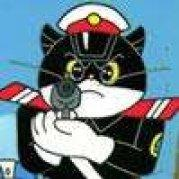

In [6]:
img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
if len(img.shape) == 3 and img.shape[2] == 4:
    img_mode = 'RGBA'
else:
    img_mode = None
    
print(f'Image shape {img.shape} mode {img_mode}')
Image(image_path)

In [7]:
with torch.no_grad():
    h_input, w_input = img.shape[0:2]

    # img: numpy
    img = img.astype(np.float32)
    if np.max(img) > 256:  # 16-bit image
        max_range = 65535
        print('\tInput is a 16-bit image')
    else:
        max_range = 255

    img = img / max_range

    if len(img.shape) == 2:  # gray image
        img_mode = 'L'
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:  # RGBA image with alpha channel
        img_mode = 'RGBA'
        alpha = img[:, :, 3]
        img = img[:, :, 0:3]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        alpha = cv2.cvtColor(alpha, cv2.COLOR_GRAY2RGB)
    else:
        img_mode = 'RGB'
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

<h3>Do image pre-processing</h3>

In [8]:
def pre_process(img):
    global mod_scale
    # Pre-process, such as pre-pad and mod pad, so that the images can be divisible
    output = torch.from_numpy(np.transpose(img, (2, 0, 1))).float() 
    output = output.unsqueeze(0).to(device)
    if half:
        output = output.half()

    # pre_pad
    if pre_pad != 0:
        outut = F.pad(output, (0, pre_pad, 0, pre_pad), 'reflect')

    # mod pad for divisible borders
    if scale == 2:
        mod_scale = 2
    elif scale == 1:
        mod_scale = 4
    if mod_scale is not None:
        mod_pad_h, mod_pad_w = 0, 0
        _, _, h, w = output.size()
        if (h % mod_scale != 0):
            mod_pad_h = (mod_scale - h % mod_scale)
        if (w % mod_scale != 0):
            mod_pad_w = (mod_scale - w % mod_scale)
        output = F.pad(output, (0, mod_pad_w, 0, mod_pad_h), 'reflect')

    return output

In [9]:
pre_processed_img = pre_process(img)

<h3>Prepare original model for inference</h3>

In [10]:
model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)
loadnet = torch.load('RealESRGAN_x4plus.pth', map_location = torch.device('cpu'))

In [11]:
# prefer to use params_ema
if 'params_ema' in loadnet:
    keyname = 'params_ema'
else:
    keyname = 'params'
model.load_state_dict(loadnet[keyname], strict=True)

<All keys matched successfully>

In [12]:
model.eval()
model = model.to(device)
if half:
    model = model.half()

<h3>Compile model for Inferentia</h3>

In [13]:
%%time
neuron_model_path = "RealESRGAN_x4plus_neuron.pt"
if not os.path.exists(neuron_model_path):
    neuron_model = torch_neuronx.trace(model, pre_processed_img)
    torch.jit.save(neuron_model, neuron_model_path)
else:
    neuron_model = torch.jut.load(neuron_model_path)

CPU times: user 13.3 s, sys: 1.88 s, total: 15.2 s
Wall time: 23min 10s


<h3>Process image with both models</h3>

In [14]:
def tile_process(img, model):
    #  It will first crop input images to tiles, and then process each tile.
    #  Finally, all the processed tiles are merged into one images.
    batch, channel, height, width = img.shape
    output_height = height * scale
    output_width = width * scale
    output_shape = (batch, channel, output_height, output_width)

    # start with black image
    output = img.new_zeros(output_shape)
    tiles_x = math.ceil(width / tile_size)
    tiles_y = math.ceil(height / tile_size)

    # loop over all tiles
    for y in range(tiles_y):
        for x in range(tiles_x):
            # extract tile from input image
            ofs_x = x * tile_size
            ofs_y = y * tile_size
            # input tile area on total image
            input_start_x = ofs_x
            input_end_x = min(ofs_x + tile_size, width)
            input_start_y = ofs_y
            input_end_y = min(ofs_y + tile_size, height)

            # input tile area on total image with padding
            input_start_x_pad = max(input_start_x - tile_pad, 0)
            input_end_x_pad = min(input_end_x + tile_pad, width)
            input_start_y_pad = max(input_start_y - tile_pad, 0)
            input_end_y_pad = min(input_end_y + tile_pad, height)

            # input tile dimensions
            input_tile_width = input_end_x - input_start_x
            input_tile_height = input_end_y - input_start_y
            tile_idx = y * tiles_x + x + 1
            input_tile = img[:, :, input_start_y_pad:input_end_y_pad, input_start_x_pad:input_end_x_pad]

            # upscale tile
            try:
                with torch.no_grad():
                    output_tile = model(input_tile)
            except RuntimeError as error:
                print('Error', error)
            print(f'\tTile {tile_idx}/{tiles_x * tiles_y}')

            # output tile area on total image
            output_start_x = input_start_x * scale
            output_end_x = input_end_x * scale
            output_start_y = input_start_y * scale
            output_end_y = input_end_y * scale

            # output tile area without padding
            output_start_x_tile = (input_start_x - input_start_x_pad) * scale
            output_end_x_tile = output_start_x_tile + input_tile_width * scale
            output_start_y_tile = (input_start_y - input_start_y_pad) * scale
            output_end_y_tile = output_start_y_tile + input_tile_height * scale

            # put tile into output image
            output[:, :, output_start_y:output_end_y, output_start_x:output_end_x] =\
                output_tile[:, :, output_start_y_tile:output_end_y_tile, output_start_x_tile:output_end_x_tile]
    return output

In [15]:
def process(img, model):
    return model(img)

In [16]:
%%time
if tile_size > 0:
    model_output = tile_process(pre_processed_img, model)
else:
    model_output = model(pre_processed_img)

CPU times: user 18.7 s, sys: 5.55 s, total: 24.3 s
Wall time: 1.52 s


In [18]:
%%time
if tile_size > 0:
    neuron_model_output = tile_process(pre_processed_img, neuron_model)
else:
    neuron_model_output = process(pre_processed_img, neuron_model)

CPU times: user 1min 6s, sys: 4.01 s, total: 1min 10s
Wall time: 1min 13s


<h3>Convert model output into image file</h3>

In [19]:
def post_process(img):
    global mod_scale
    
    output = img
    
    # remove extra pad
    if mod_scale is not None:
        _, _, h, w = output.size()
        output = output[:, :, 0:h - mod_pad_h * scale, 0:w - mod_pad_w * scale]
    
    # remove prepad
    if pre_pad != 0:
        _, _, h, w = output.size()
        output = output[:, :, 0:h - pre_pad * scale, 0:w - pre_pad * scale]
    
    return output

In [20]:
post_processed_output = post_process(model_output)
post_processed_output = post_processed_output.data.squeeze().float().cpu().clamp_(0, 1).numpy()
post_processed_output = np.transpose(post_processed_output[[2, 1, 0], :, :], (1, 2, 0))

In [21]:
post_processed_neuron_output = post_process(neuron_model_output)
post_processed_neuron_output = post_processed_neuron_output.data.squeeze().float().cpu().clamp_(0, 1).numpy()
post_processed_neuron_output = np.transpose(post_processed_neuron_output[[2, 1, 0], :, :], (1, 2, 0))

In [22]:
if img_mode == 'L':
    post_processed_output = cv2.cvtColor(post_processed_output, cv2.COLOR_BGR2GRAY)
    post_processed_neuron_output = cv2.cvtColor(post_processed_neuron_output, cv2.COLOR_BGR2GRAY)

In [23]:
if img_mode == 'RGBA':
    if alpha_upsampler == 'realesrgan':
        pre_processed_alpha = pre_process(alpha)
        
        if tile_size > 0:
            output_alpha = tile_process(pre_processed_alpha, model)
            neuron_output_alpha = tile_process(pre_processed_alpha, neuron_model)
        else:
            output_alpha = process(pre_processed_alpha, model)
            neuron_output_alpha = process(pre_processed_alpha, neuron_model)
        
        output_alpha = post_process(output_alpha)
        output_alpha = output_alpha.data.squeeze().float().cpu().clamp_(0, 1).numpy()
        output_alpha = np.transpose(output_alpha[[2, 1, 0], :, :], (1, 2, 0))
        output_alpha = cv2.cvtColor(output_alpha, cv2.COLOR_BGR2GRAY)

        neuron_output_alpha = post_process(neuron_output_alpha)
        neuron_output_alpha = neuron_output_alpha.data.squeeze().float().cpu().clamp_(0, 1).numpy()
        neuron_output_alpha = np.transpose(neuron_output_alpha[[2, 1, 0], :, :], (1, 2, 0))
        neuron_output_alpha = cv2.cvtColor(neuron_output_alpha, cv2.COLOR_BGR2GRAY)
        

    else:  # use the cv2 resize for alpha channel
        h, w = alpha.shape[0:2]
        output_alpha = cv2.resize(alpha, (w * scale, h * scale), interpolation=cv2.INTER_LINEAR)
        neuron_output_alpha = outphut_alpha

    # merge the alpha channel
    post_processed_output = cv2.cvtColor(post_processed_output, cv2.COLOR_BGR2BGRA)
    post_processed_output[:, :, 3] = output_alpha
    
    post_processed_neuron_output = cv2.cvtColor(post_processed_neuron_output, cv2.COLOR_BGR2BGRA)
    post_processed_neuron_output[:, :, 3] = neuron_output_alpha

In [24]:
if max_range == 65535:  # 16-bit image
    post_processed_output = (post_processed_output * 65535.0).round().astype(np.uint16)
    post_processed_neuron_output = (post_processed_neuron_output * 65535.0).round().astype(np.uint16)
else:
    post_processed_output = (post_processed_output * 255.0).round().astype(np.uint8)
    post_processed_neuron_output = (post_processed_neuron_output * 255.0).round().astype(np.uint8)

In [25]:
if outscale is not None and outscale != float(scale):
    img_output = cv2.resize(
                post_processed_output, (
                    int(w_input * outscale),
                    int(h_input * outscale),
                ), interpolation=cv2.INTER_LANCZOS4)
    
    img_neuron_output = cv2.resize(
                post_processed_neuron_output, (
                    int(w_input * outscale),
                    int(h_input * outscale),
                ), interpolation=cv2.INTER_LANCZOS4)
    
else:
    img_output = post_processed_output
    img_neuron_output = post_processed_neuron_output

In [27]:
name, ext = image_path.split(".")
output_image_path = f"{name}_output.png"
neuron_output_image_path = f"{name}_output_neuron.png"
cv2.imwrite(output_image_path, img_output)
cv2.imwrite(neuron_output_image_path, img_neuron_output)

True

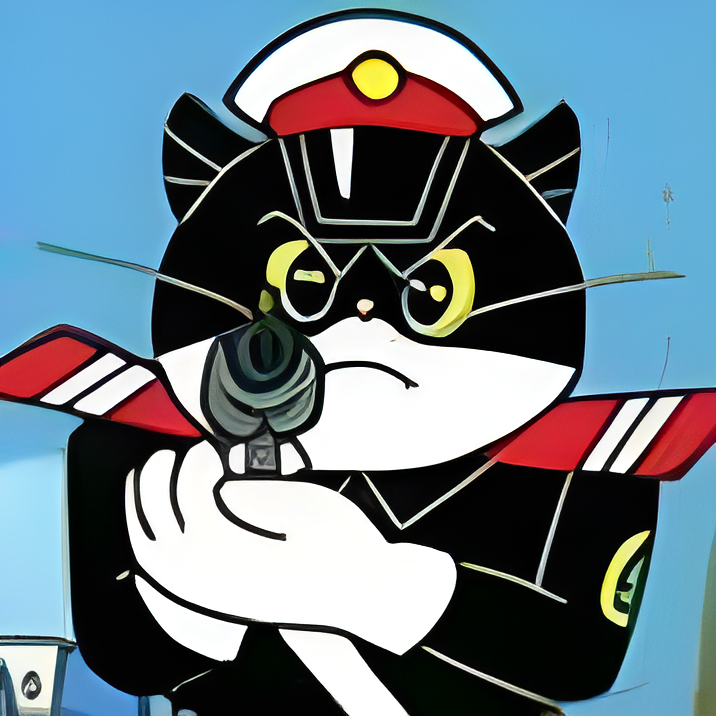

In [29]:
Image(output_image_path)


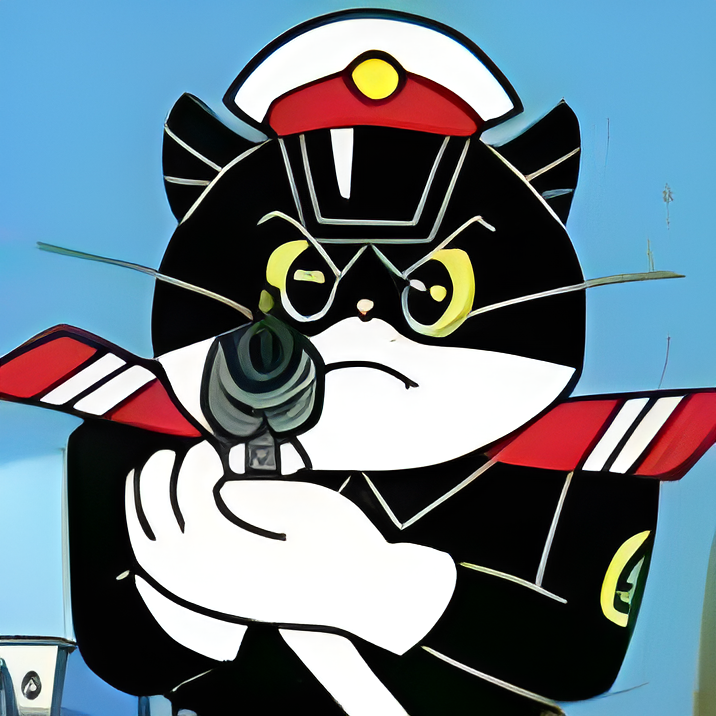

In [30]:
Image(neuron_output_image_path)